In [6]:
from google.colab import data_table, drive
import os

data_table.enable_dataframe_formatter()
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/DSC 245 - Intro to Causal Inference"

!pip install pyAgrum==1.1.0
!pip install causalml
!pip install causal-learn

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 6.5 MB/s eta 0:00:00



## This notebook extracts correlation between features based on Bayesian Network
The edge links are extraxted from the Bayesian Net, which later used to construct graph for uplift modelling

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
from pylab import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from pyAgrum.lib.bn2roc import showROC
from collections import Counter
from IPython.core.display import display, HTML
import time
import logging
import random
random.seed(2022)
np.random.seed(2022)


# Some formatting
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 4 decimal points
pd.set_option('display.max_columns', None)

display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Path
path = ''

## 1 Define Function

from bayes_function import *

In [3]:
# Functions
def missing(df,perc=0):
    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ['column', 'missing count']
    missing_df['percentage']=(missing_df['missing count'])/df.shape[0]*100
    missing_df = missing_df[missing_df.percentage>perc]
    print('#columns containing missing values',len(missing_df))
    print("missing_columns=" , list(missing_df.column))
    return missing_df.sort_values(by='percentage',ascending=False)

def show_unique(df):
    '''Show columns that have only one value (i.e. there is no variation to exploit)'''
    counts = pd.DataFrame()
    counts['nunique'] = df.nunique()

    counts = counts[counts['nunique'] == 1]
    print('These columns only have one value:', list(counts.index))
    return counts

def fill_null(df, attribute_list, stat = 'intger', integer = -999):
    """
    This function fills null values of selected columns with one of four different methods:
        - 'median' will fill the nulls with the median of the column.
        - 'mean' uses the mean of the column.
        - 'mode' uses the mode of the column. It can be used with string
        variables, but they need to have been encoded first.
        - 'integer' fills the nulls with an integer (-999 by default).
    """
    for i in attribute_list:
        if stat == 'median':
            df[i].fillna(df[i].median(), inplace=True)
        elif stat == 'mean':
            df[i].fillna(df[i].mean(), inplace=True)
        elif stat == 'mode':
            df[i].fillna(df[i].mode()[0], inplace=True)
        elif stat == 'integer':
            df[i].fillna(integer, inplace=True)

    return df

## JPD  joint pro bability density
def get_jpd_size(bn):
    return np.prod([bn.variable(node).domainSize() for node in bn.nodes()])


### bn.cpt
def get_cpts_size(bn):
    return sum([np.prod(bn.cpt(node).var_dims) for node in bn.nodes() ])

def compression_ratio(bn):
    return 100*(1-get_cpts_size(bn)/ get_jpd_size(bn))

def post(row,bn,target):
        ie = gum.LazyPropagation(bn)
        evs = row.astype(str).to_dict()
        #print(evs)
        del evs[target]
        ie.setEvidence(evs)
        ie.addTarget(target)
        return ie.posterior(target).toarray()[1]


In [4]:
# Wrapper class
class BNEstimator(BaseEstimator, ClassifierMixin):
    """
    csv_template is used to create the modalities for the BN"""
    def __init__(self,
                 csv_template=None,
                 bn=None,
               mandatory_arcs=[],
               tabu_arcs=[],
               class_name = None,
               learning_method='greedy',
               prior='likelihood',
               prior_weight=.5,
               positif_label = None,
               threshold = .5,
               nb_classes = 2,
               cut_points_percentiles  = list(100*np.linspace(0, 1,5)),
               bins=5):


        self.csv_template = csv_template
        self.mandatory_arcs = mandatory_arcs
        self.tabu_arcs = tabu_arcs
        self.class_name = class_name

        ### learning_method
        self.learning_method = learning_method

        ### prior
        self.prior = prior
        self.prior_weight = prior_weight
        self.positif_label = positif_label
        self.threshold = threshold
        self.nb_classes = nb_classes
        self.cut_points_percentiles = cut_points_percentiles
        self.bins = bins
        self.bn = bn


    def get_params(self, deep=True):
        return {"csv_template":self.csv_template,# template for modalities
            "class_name":self.class_name,
            "mandatory_arcs": self.mandatory_arcs,
                "tabu_arcs":self.tabu_arcs,
                "learning_method": self.learning_method,
               "prior": self.prior,
               "prior_weight":  self.prior_weight,
              "class_name"  :self.class_name ,
              "positif_label"  :self.positif_label ,
              "threshold" : self.threshold ,
              "nb_classes"  :self.nb_classes ,
              "cut_points_percentiles"  :self.cut_points_percentiles,
            "bins" : self.bins}


    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


    def transform(self,d):
        """Transfrom the whole dataset before training
        param d : dataframe
        """
        template = gum.BayesNet()
        numeric_cols = list(d.select_dtypes(include=[np.number]).columns)
        categorical_cols = list(d.select_dtypes(include=[object]).columns)


        for col in numeric_cols:
            if d[col].value_counts().shape[0]>self.bins:
                x = d[col].values.flatten()
                x.sort()
                cut_points = np.percentile(x, self.cut_points_percentiles)
                d.loc[:,col]= np.digitize(x, cut_points, right=False)
                del x
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        for col in categorical_cols:
            if d[col].value_counts().shape[0]>self.bins:
                top = d[col].isin(d[col].value_counts().index[:self.bins])
                d.loc[~top, col] = "else_top_"+str(self.bins)

                del top
            template.add(gum.LabelizedVariable(col,col,list(map(str,d[col].value_counts().index))))
        return template,d


    def fit(self,data,y=None):
        """Create the template and Fit the training dataset: data_file"""

        # create the template
        template,_ = self.transform(pd.read_csv(self.csv_template))
        _,train= self.transform(data)


        train.to_csv('train_bn.csv',index=False)
        learner = gum.BNLearner('train_bn.csv', template)


        for i in self.tabu_arcs: learner.addForbiddenArc(i[0],i[1])
        for i in self.mandatory_arcs :  learner.addMandatoryArc(i[0],i[1])

        if self.learning_method == 'greedy':learner.useGreedyHillClimbing()
        else: learner.useMIIC()

        if self.prior == "laplace":learner.useAprioriSmoothing(self.prior_weight)
        else:learner.useNoApriori()


        self.bn = learner.learnBN()
        self.bn = learner.learnParameters(self.bn.dag())
        del template,train

        return self

    def predict_one_row(self,row):
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name)

        evs = row.astype(str).to_dict()
        del evs[self.class_name]
        ie.setEvidence(evs)
        ie.makeInference()
        return ie.posterior(self.class_name).toarray()


    def predict_proba1(self,test):#,mb=True):
        scores = np.empty([test.shape[0], self.nb_classes])
        scores[:] = np.nan
        ie = gum.LazyPropagation(self.bn)
        ie.addTarget(self.class_name)

        for i in range(len(test)):
            evs = test.iloc[i,:].astype(str).to_dict()
            del evs[self.class_name]
            ie.setEvidence(evs)
            ie.makeInference()
            scores[i] = ie.posterior(self.class_name).toarray()
        return scores


    def predict_proba(self, Xtest):
        if type(Xtest) is np.ndarray:
            Xtest = pd.DataFrame(Xtest, columns=["X{}".format(i) for i in range(Xtest.shape[1])])

        Yscores = np.empty([Xtest.shape[0], self.nb_classes])
        Yscores[:] = np.nan

        mbnames = [self.bn.variable(i).name()
                   for i in gum.MarkovBlanket(self.bn, self.class_name).nodes()
                   if self.bn.variable(i).name() != self.class_name]
        ie = gum.LazyPropagation(self.bn)
        for var in ie.BN().names():
            if var != self.class_name:
                ie.addEvidence(var, 0)
        ie.addTarget(self.class_name)

        Xtest = Xtest.reset_index(drop=True)

        for line in Xtest.itertuples():
            for var in mbnames:
                try:
                    idx = self.bn.variable(var).index(str(getattr(line, var)))
                    ie.chgEvidence(var, idx)
                except gum.GumException:
                # this can happen when value is missing is the test base.
                    print("[pyAgrum] ** pyAgrum.lib.classifier : The value {getattr(line, var)} for the variable {var} is missing in the training set.")
                    pass

            ie.makeInference()

            marginal = ie.posterior(self.class_name)
            Yscores[line[0]] = marginal.toarray()

        return Yscores


    def predict(self,test):
        y_scores = self.predict_proba(test)[:,1]
        y_true = test[self.class_name]

        return y_true, np.where(y_scores >= self.threshold, 1, 0)


    def score(self,test):
        from sklearn.metrics import recall_score, f1_score, classification_report
        y_true,y_pred = self.predict(test)
        print(classification_report(y_true, y_pred))
        print(5*'--')
        print('recall_score')
        return recall_score(y_true, y_pred)

## 2 Model Training

In [5]:
import causalml
from causalml.dataset import *
#y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=9, sigma=1.0)
df=pd.read_csv(os.path.join(data_path,"criteo-uplift-v2.1.csv"))
print('Dimensions of data:', df.shape)
df.head()

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


Dimensions of data: (13979592, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616,10.060,8.976,4.680,10.281,4.115,0.294,4.834,3.955,13.190,5.300,-0.169,1,0,0,0
1,12.616,10.060,9.003,4.680,10.281,4.115,0.294,4.834,3.955,13.190,5.300,-0.169,1,0,0,0
2,12.616,10.060,8.965,4.680,10.281,4.115,0.294,4.834,3.955,13.190,5.300,-0.169,1,0,0,0
3,12.616,10.060,9.003,4.680,10.281,4.115,0.294,4.834,3.955,13.190,5.300,-0.169,1,0,0,0
4,12.616,10.060,9.038,4.680,10.281,4.115,0.294,4.834,3.955,13.190,5.300,-0.169,1,0,0,0


In [ ]:
df.dropna(inplace=True)
df.drop(columns='conversion').to_csv('template.csv', index = False)

clf = BNEstimator(csv_template='template.csv', class_name='conversion',
                  cut_points_percentiles = [5, 50, 95])
_,data = clf.transform(df)

train,test = train_test_split(data ,test_size=0.25, random_state=42)
train.to_csv('train.csv',index=False)

clf.fit(train)

BNEstimator(class_name='conversion', csv_template='template.csv',
            cut_points_percentiles=[5, 50, 95])

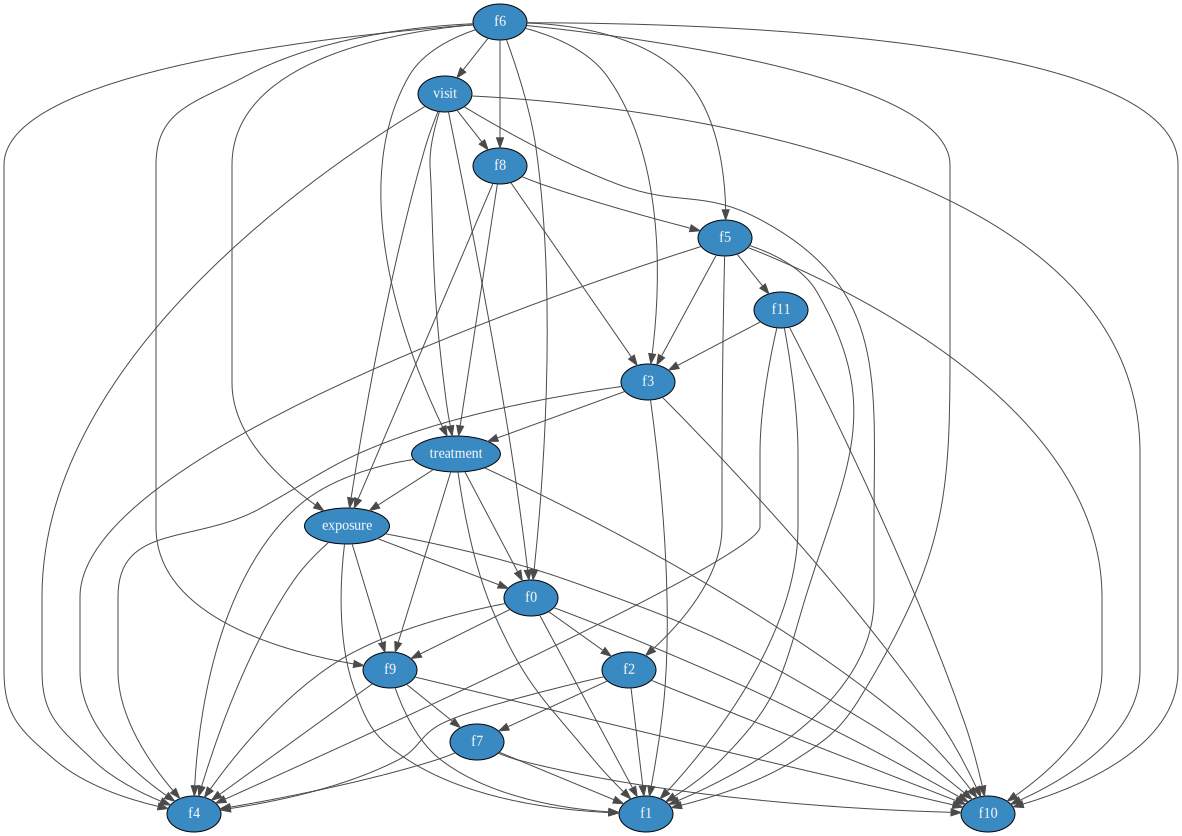

In [ ]:
gnb.showBN(clf.bn,size=20,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('Blues'))

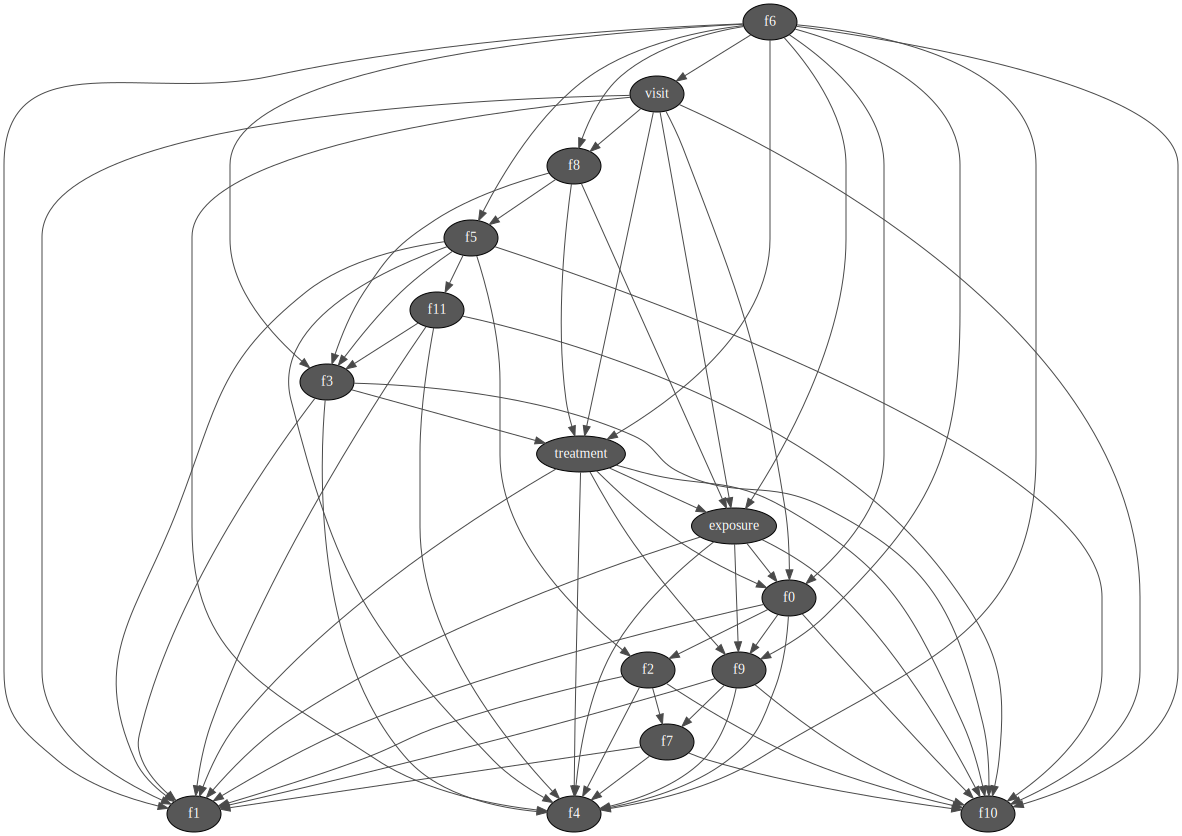

In [ ]:
gnb.showBN(clf.bn,size=20,nodeColor={n:0.66 for n in clf.bn.names()},cmap=plt.cm.get_cmap('gist_gray_r'))

In [ ]:
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [ ]:
len(clf.bn.names()), len(df.columns)

(15, 16)

 ## 2.5 GES

In [22]:
from causallearn.search.ScoreBased.GES import ges

Record = ges(df.drop(columns='conversion').sample(100000).to_numpy(), 'local_score_BIC')

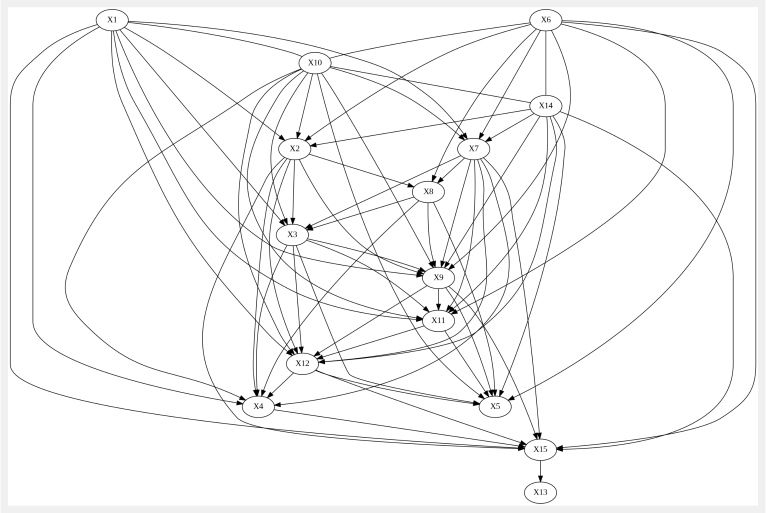

In [26]:
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'])
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
ax.axis('off')
ax.imshow(img)
plt.show()

 ## 3 Extract Edge List from BN

In [ ]:
for i in list(gnb.getSideBySide(clf.bn).split("\n")):
    if str('edge') in i:
        if str('xlink:title')  in i:
            string=i[-13:-5].strip("=\"\()")
            print(string)
            start=string.split(",")[0]
            end=string.split(",")[1]

5, 10
5, 4
5, 1
5, 2
5, 11
5, 3
9, 10
9, 4
9, 1
9, 7
0, 9
0, 10
0, 4
0, 1
0, 2
6, 5
6, 9
6, 0
6, 10
6, 4
6, 12
6, 1
6, 13
6, 14
6, 8
6, 3
12, 9
12, 0
12, 10
12, 4
12, 1
12, 14
2, 10
2, 4
2, 1
2, 7
7, 10
7, 4
7, 1
11, 10
11, 4
11, 1
11, 3
13, 0
13, 10
13, 4
13, 12
13, 1
13, 14
13, 8
14, 9
14, 0
14, 10
14, 4
14, 1
8, 5
8, 12
8, 14
8, 3
3, 10
3, 4
3, 12
3, 1


In [ ]:
start_df=[]
end_df=[]
edge_df=pd.DataFrame(columns=['start','end'])
for i in list(gnb.getSideBySide(clf.bn).split("\n")):
    if str('edge') in i:
        if str('xlink:title')  in i:
            string=i[-13:-5].strip("=\"\()")
            #print(string)
            start=string.split(",")[0]
            end=string.split(",")[1]

            start_df.append(start)
            end_df.append(end)
edge_df['start']=start_df+ end_df+[i for i in range(9)]+ list(int(i) for i in np.ones(9)*9)
edge_df['end']=end_df +start_df+list(int(i) for i in np.ones(9)*9)+[i for i in range(9)]

edge_df.to_csv(os.path.join(data_path,'criteo_edge_index.csv'),index=False)

In [ ]:
start_df=[]
end_df=[]
edge_df=pd.DataFrame(columns=['start','end'])
for i in list(gnb.getSideBySide(clf.bn).split("\n")):
    if str('edge') in i:
        if str('xlink:title')  in i:
            string=i[-13:-5].strip("=\"\()")
            #print(string)
            start=string.split(",")[0]
            end=string.split(",")[1]

            if int(start)!=14 and int(end)!=14:
                if int(start)==12:
                    start='13'
                elif int(start)==13:
                    start='12'
                if int(end)==12:
                    end='13'
                elif int(end)==13:
                    end='12'
                start_df.append(start)
                end_df.append(end)
edge_df['start']=start_df
edge_df['end']=end_df

edge_df.to_csv(os.path.join(data_path,'criteo_edge_index_14.csv'),index=False)

Record[‘G’]: learned causal graph, where Record[‘G’].graph[j,i]=1 and Record[‘G’].graph[i,j]=-1 indicate i –> j; Record[‘G’].graph[i,j] = Record[‘G’].graph[j,i] = -1 indicates i — j.

In [33]:
print(Record['G'])

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8;X9;X10;X11;X12;X13;X14;X15

Graph Edges:
1. X1 --> X2
2. X1 --> X3
3. X1 --> X4
4. X1 --> X7
5. X1 --> X9
6. X1 --- X10
7. X1 --> X11
8. X1 --> X12
9. X1 --> X15
10. X2 --> X3
11. X2 --> X4
12. X6 --> X2
13. X2 --> X8
14. X2 --> X9
15. X10 --> X2
16. X2 --> X12
17. X14 --> X2
18. X2 --> X15
19. X3 --> X4
20. X3 --> X5
21. X7 --> X3
22. X8 --> X3
23. X3 --> X9
24. X10 --> X3
25. X3 --> X11
26. X3 --> X12
27. X7 --> X4
28. X8 --> X4
29. X10 --> X4
30. X12 --> X4
31. X4 --> X15
32. X6 --> X5
33. X8 --> X5
34. X9 --> X5
35. X10 --> X5
36. X11 --> X5
37. X12 --> X5
38. X14 --> X5
39. X6 --> X7
40. X6 --> X8
41. X6 --> X9
42. X6 --- X10
43. X6 --> X11
44. X6 --- X14
45. X6 --> X15
46. X7 --> X8
47. X7 --> X9
48. X10 --> X7
49. X7 --> X11
50. X7 --> X12
51. X14 --> X7
52. X7 --> X15
53. X8 --> X9
54. X10 --> X9
55. X9 --> X11
56. X9 --> X12
57. X14 --> X9
58. X9 --> X15
59. X10 --> X11
60. X10 --> X12
61. X10 --- X14
62. X11 --> X12
63. X14 --> X11
64. X14

In [39]:
start_df=[]
end_df=[]
edge_df=pd.DataFrame(columns=['start','end'])
for i in range(14):
    for j in range(14):
        if Record['G'].graph[i,j]==-1:
            start=i
            end=j

            if int(start)!=14 and int(end)!=14:
                if int(start)==12:
                    start=13
                elif int(start)==13:
                    start=12
                if int(end)==12:
                    end=13
                elif int(end)==13:
                    end=12
                start_df.append(start)
                end_df.append(end)
edge_df['start']=start_df
edge_df['end']=end_df

edge_df.to_csv(os.path.join(data_path,'criteo_edge_index_ges_14.csv'),index=False)